In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [2]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

total_variation_weight = 5e-7
style_weight = 1e-5
content_weight = 2.5e-8

#
#total_variation_weight = 1e-8
#style_weight = 5e-5 #generated6
#content_weight = 1e-10

In [89]:
base_image_path = "bukhansan.jpg"
#style_reference_image_path = "g8007.jpg"
style_reference_image_path = keras.utils.get_file(
    "franz-marc.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg/691px-Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg"
)
result_prefix = 'bukhan_generated'

131072/117408 [=================================] - 0s 4us/step


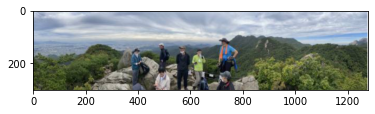

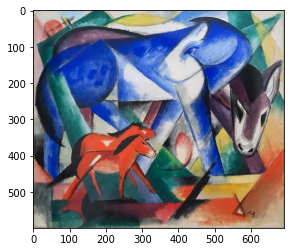

In [90]:
from matplotlib import image as mp_image
import matplotlib.pyplot as plt
img = mp_image.imread(base_image_path)
plt.imshow(img)
plt.show()

img = mp_image.imread(style_reference_image_path)
plt.imshow(img)
plt.show()

In [91]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [92]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [93]:
# 이미지 텐서의 gram matrix (특징별 outer product)

def gram_matrix(x):
    # 채널을 맨 앞으로, w,h를 뒤로 보냄
    x = tf.transpose(x, (2, 0, 1)) 
    # (c, h, w) ==> (c, w*h)
    features = tf.reshape(x, (tf.shape(x)[0], -1)) 
    # (c, w*h) x (w*h,c) = (c,c) 
    gram = tf.matmul(features, tf.transpose(features))  
    return gram

In [94]:
# style loss는 reference image와 generated image간의 
# 스타일 차이를 유지할 수 있도록 하는 역할을 한다.
# gram matrix의 차이의 squared error로 정의

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    # 논문의 정확한 implementation은 다음과 같아야 함
    # channels = style.shape[2]
    # size = style.shape[0] * style.shape[1] 
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [95]:
# 콘텐츠 손실 함수
# 생성된 이미지에서 base 이미지의 "content"를
# 유지하기 위함

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [96]:
# 3번째 손실함수: total variation loss
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [97]:
# VGG19 model 로딩 (pre-trained ImageNet weights)
model = vgg19.VGG19(weights="imagenet", include_top=False)
model.summary()

# 모델에서 레이어 이름과 레이어 출력 형식을 가져옴
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# VGG 모델의 전체 activation value를 출력하는 함수 정의
# (dict 형식)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [98]:
# style loss에 사용할 레이어
#style_layer_names = [
#    "block1_conv1",
#    "block2_conv1",
#    "block3_conv1",
#    "block4_conv1",
#    "block5_conv1",
#]

style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv2",
    "block4_conv2",
    "block5_conv2",
]

# content loss에 사용할 레이어
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # loss 초기화
    loss = tf.zeros(shape=())

    # content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    c_loss = content_weight * content_loss(
        base_image_features, combination_features
    )
    s_loss = tf.zeros(shape=())
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        s_loss += (style_weight / len(style_layer_names)) * sl
    
    # total variation loss
    t_loss = total_variation_weight * total_variation_loss(combination_image)
    loss = c_loss+s_loss+t_loss 
    return loss, c_loss, s_loss, t_loss

In [99]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, t_loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, c_loss, s_loss, t_loss

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads, c_loss, s_loss, t_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0 or i == 1:
        print("Iteration %d: loss=%.2f, content_loss=%.2f, style_loss=%.2f, total_variation_loss=%.2f" %
               (i, loss, c_loss, s_loss, t_loss))
    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=238733.53, content_loss=0.00, style_loss=238117.25, total_variation_loss=616.28
Iteration 10: loss=114338.91, content_loss=40.61, style_loss=113352.44, total_variation_loss=945.86
Iteration 20: loss=74105.45, content_loss=47.11, style_loss=72990.52, total_variation_loss=1067.82
Iteration 30: loss=58168.30, content_loss=48.75, style_loss=57000.16, total_variation_loss=1119.39
Iteration 40: loss=51027.80, content_loss=49.68, style_loss=49827.27, total_variation_loss=1150.84
Iteration 50: loss=45802.15, content_loss=50.22, style_loss=44585.67, total_variation_loss=1166.26
Iteration 60: loss=42027.18, content_loss=50.60, style_loss=40801.84, total_variation_loss=1174.74
Iteration 70: loss=38920.90, content_loss=50.95, style_loss=37690.36, total_variation_loss=1179.58
Iteration 80: loss=35993.49, content_loss=51.29, style_loss=34761.50, total_variation_loss=1180.70
Iteration 90: loss=33488.05, content_loss=51.62, style_loss=32255.94, total_variation_loss=1180.49
Iteration 

Iteration 840: loss=3001.79, content_loss=56.18, style_loss=1892.24, total_variation_loss=1053.37
Iteration 850: loss=2978.47, content_loss=56.16, style_loss=1869.20, total_variation_loss=1053.11
Iteration 860: loss=2955.92, content_loss=56.14, style_loss=1846.92, total_variation_loss=1052.85
Iteration 870: loss=2934.11, content_loss=56.13, style_loss=1825.39, total_variation_loss=1052.59
Iteration 880: loss=2913.00, content_loss=56.11, style_loss=1804.54, total_variation_loss=1052.35
Iteration 890: loss=2892.54, content_loss=56.10, style_loss=1784.34, total_variation_loss=1052.11
Iteration 900: loss=2872.68, content_loss=56.08, style_loss=1764.73, total_variation_loss=1051.87
Iteration 910: loss=2853.44, content_loss=56.07, style_loss=1745.73, total_variation_loss=1051.64
Iteration 920: loss=2834.77, content_loss=56.05, style_loss=1727.29, total_variation_loss=1051.42
Iteration 930: loss=2816.66, content_loss=56.04, style_loss=1709.42, total_variation_loss=1051.21
Iteration 940: loss=

Iteration 1670: loss=2181.35, content_loss=54.85, style_loss=1085.39, total_variation_loss=1041.11
Iteration 1680: loss=2177.22, content_loss=54.83, style_loss=1081.38, total_variation_loss=1041.00
Iteration 1690: loss=2173.14, content_loss=54.82, style_loss=1077.42, total_variation_loss=1040.90
Iteration 1700: loss=2169.12, content_loss=54.81, style_loss=1073.52, total_variation_loss=1040.80
Iteration 1710: loss=2165.16, content_loss=54.80, style_loss=1069.67, total_variation_loss=1040.69
Iteration 1720: loss=2161.25, content_loss=54.78, style_loss=1065.88, total_variation_loss=1040.59
Iteration 1730: loss=2157.39, content_loss=54.77, style_loss=1062.14, total_variation_loss=1040.48
Iteration 1740: loss=2153.58, content_loss=54.76, style_loss=1058.44, total_variation_loss=1040.38
Iteration 1750: loss=2149.81, content_loss=54.75, style_loss=1054.79, total_variation_loss=1040.28
Iteration 1760: loss=2146.11, content_loss=54.73, style_loss=1051.20, total_variation_loss=1040.18
Iteration 

Iteration 2510: loss=1960.01, content_loss=53.93, style_loss=872.62, total_variation_loss=1033.46
Iteration 2520: loss=1958.36, content_loss=53.93, style_loss=871.05, total_variation_loss=1033.38
Iteration 2530: loss=1956.72, content_loss=53.92, style_loss=869.50, total_variation_loss=1033.30
Iteration 2540: loss=1955.09, content_loss=53.91, style_loss=867.96, total_variation_loss=1033.22
Iteration 2550: loss=1953.48, content_loss=53.90, style_loss=866.44, total_variation_loss=1033.14
Iteration 2560: loss=1951.88, content_loss=53.89, style_loss=864.93, total_variation_loss=1033.06
Iteration 2570: loss=1950.30, content_loss=53.88, style_loss=863.43, total_variation_loss=1032.99
Iteration 2580: loss=1948.72, content_loss=53.88, style_loss=861.94, total_variation_loss=1032.91
Iteration 2590: loss=1947.17, content_loss=53.87, style_loss=860.47, total_variation_loss=1032.83
Iteration 2600: loss=1945.62, content_loss=53.86, style_loss=859.00, total_variation_loss=1032.75
Iteration 2610: loss

Iteration 3350: loss=1858.55, content_loss=53.35, style_loss=777.37, total_variation_loss=1027.83
Iteration 3360: loss=1857.68, content_loss=53.35, style_loss=776.56, total_variation_loss=1027.78
Iteration 3370: loss=1856.83, content_loss=53.34, style_loss=775.77, total_variation_loss=1027.72
Iteration 3380: loss=1855.98, content_loss=53.33, style_loss=774.98, total_variation_loss=1027.67
Iteration 3390: loss=1855.13, content_loss=53.33, style_loss=774.19, total_variation_loss=1027.61
Iteration 3400: loss=1854.29, content_loss=53.32, style_loss=773.41, total_variation_loss=1027.56
Iteration 3410: loss=1853.44, content_loss=53.32, style_loss=772.62, total_variation_loss=1027.51
Iteration 3420: loss=1852.62, content_loss=53.31, style_loss=771.85, total_variation_loss=1027.45
Iteration 3430: loss=1851.80, content_loss=53.31, style_loss=771.09, total_variation_loss=1027.40
Iteration 3440: loss=1850.97, content_loss=53.30, style_loss=770.33, total_variation_loss=1027.34
Iteration 3450: loss